# Forward dynamics of infection on Zachary’s karate club data
Comparison with Fig. 2 in *Ortega et. al*, [Dynamics of epidemics from cavity master equations: Susceptible-infectious-susceptible models](https://doi.org/10.1103/PhysRevE.105.024308)

In [1]:
using MatrixProductBP, MatrixProductBP.Models
using IndexedGraphs, DelimitedFiles, Plots
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using JLD2;

┌ Info: Precompiling MatrixProductBP [3d39929c-b583-45fa-b331-3f50b693a38a]
└ @ Base loading.jl:1662


In [2]:
# read matrix of contacts, found at http://konect.cc/networks/ucidata-zachary/
A = readdlm("karate.txt", Bool)
g = IndexedGraph(A);

In [3]:
N = nv(g)  # number of individuals
T = 50     # final time
ΔT = 1.0   # discretization
λ = 0.1    # prob. of transmission
ρ = 0.05   # prob. of recovery

# adjust probabilities and number of discrete time steps to simulate continuous-time behavior
sis = SIS(g, λ*ΔT, ρ*ΔT, floor(Int, T/ΔT))

# prob. of being infected at time zero
for i in 1:N
   if i == 1
        sis.ϕ[i][1] .*= [0.0, 1.0]   # node 1 is infected at time zero
    else
        sis.ϕ[i][1] .*= [1.0, 0.0]   # all other nodes start as susceptible
    end
end

# set up MPBP computation
bp = mpbp(sis)
cb = CB_BP(bp);

In [4]:
svd_trunc = TruncBond(4)   # maximum matrix size for SVD-based truncation
maxiter = 100
tol = 1e-6

# run MPBP
iters, cb = iterate!(bp; cb, svd_trunc, maxiter, tol);

Running MPBP: iter 8 	 Time: 0:01:46
  Δ:  6.517561538491152e-7

In [5]:
if iters < maxiter
    println("BP converged after $iters iterations")
else
    println("BP did not meet criteria for convergence after $maxiter iterations")
end

BP converged after 8 iterations


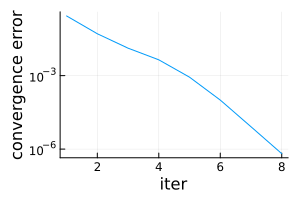

In [6]:
plot(cb.Δs, ylabel="convergence error", xlabel="iter", yaxis=:log10, 
    size=(300,200), label="")

In [7]:
# compute marginals
b_bp = beliefs(bp)
p29_bp = [bb[INFECTED] for bb in b_bp[29]];

In [8]:
# instantiate Soft Margin sampler
sms = SoftMarginSampler(bp);

In [9]:
# draw samples
# re-run this cell (but not the one above!) to draw more samples and refine the estimate
nsamples_mc = 10^5
sample!(sms, nsamples_mc);

SoftMargin sampling 100%|████████████████████████████████| Time: 0:02:299:25


In [10]:
# b_mc = marginals(sms)
# p29_mc = [bb[INFECTED] for bb in b_mc[29]];

In [11]:
# discard monte carlo runs with no infected at final time
# this is to compare with the results in the paper
ids = findall(!all(x[:,end] .== SUSCEPTIBLE) for x in sms.X)
Xnew = sms.X[ids]
wnew = sms.w[ids]
sms_new = SoftMarginSampler(bp, Xnew, wnew)
b_mc = marginals(sms_new)
p29_mc = [bb[INFECTED] for bb in b_mc[29]];

In [39]:
pl = plot(xlabel="time", xticks=0:10:T, ylabel="\$P(x_{29}^t=I)\$", ylims=(-0.05,1), legend=:bottomright)
plot!(pl, 0:ΔT:T, p29_bp, m=:o, ms=2, label="MPBP")
plot!(pl, 0:ΔT:T, p29_mc, m=:x, ms=2, label="MC")
ylims = extrema((p29_bp[end], p29_mc[end].val)) .+ (-1, 1) .* 0.05
plot!(pl, xticks=T-20:4:T, ylims=ylims, xlims=(T-20,T),
    inset=(1, bbox(0.5, 0.3, 0.45, 0.4)), subplot=2)
plot!(pl[2], 0:ΔT:T, p29_bp, m=:o, ms=2, label="")
plot!(pl[2], 0:ΔT:T, p29_mc, m=:x, ms=2, label="");

In [40]:
pl_err = plot(xlabel="time", xticks=0:10:T) #, ylims=(-0.01,0.3))
plot!(pl_err, 0:ΔT:T, p29_bp.-p29_mc, label="", ylabel="L₁-error");

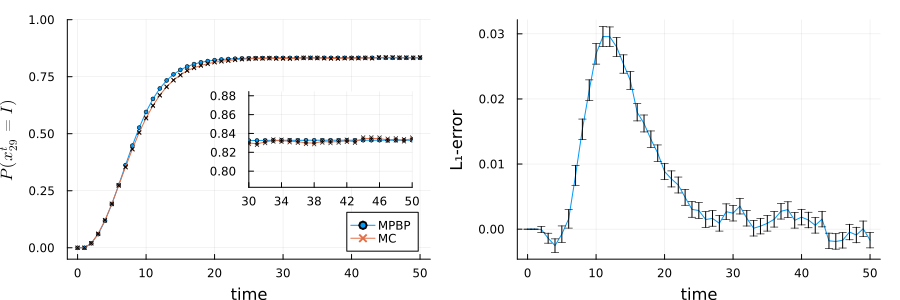

In [41]:
plot(pl, pl_err, size=(900,300), margin=3Plots.mm)

In [15]:
c = autocovariances(bp);

In [16]:
using ColorSchemes
function plot_autocovs(c, T; kw...)
    us = 10:10:T
    cg = cgrad(:matter, length(us), categorical=true)
    ylabel = "\$\\langle x_{29}^t x_{29}^{t+\\Delta t}\\rangle-" * 
        "\\langle x_{29}^t\\rangle\\langle x_{29}^{t+\\Delta t}\\rangle \$"
    xlabel = "\$\\Delta t \$"
    pl = plot(;xlabel, ylabel, legend=:outertopright, 
        title="SIS karate club. λ = $λ, ρ = $ρ")
     
    for (j,u) in enumerate(us)
        plot!(pl, u:-1:1, c[(0:u-1) .+ 1,u+1], label="t+Δt=$u", c=cg[j], m=:o, msc=cg[j]; kw...) 
    end
    pl
end  

plot_autocovs (generic function with 1 method)

In [17]:
c29 = map(x -> x > 0 ? x : NaN, c[29]);

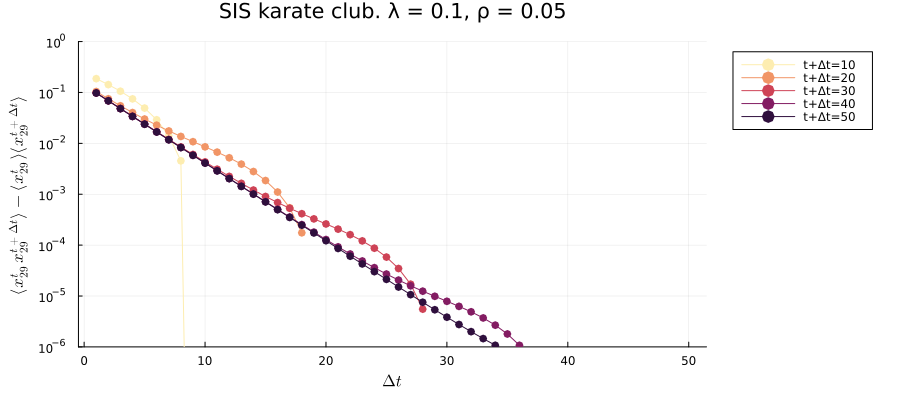

In [18]:
pl_autocov = plot_autocovs(c29, floor(Int, T/ΔT); yaxis=(:log10, (1e-6,1e-0)), 
    size=(900,400), margin=5Plots.mm)

In [43]:
jldsave("plot_data/sis_karate_club_network.jld2"; T, ΔT, p29_bp, p29_mc, c, λ, ρ, svd_trunc);